# Naive Classifier for Fake news recognition

## Packages

In [1]:
library(tidyverse)
library(ggplot2)
library(stopwords)
library(tidytext)
library(stringr)
library(purrr)
library(magrittr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Caricamento pacchetto: ‘magrittr’


Il seguente oggetto è mascherato da ‘package:purrr’:

    set_names


Il seguente oggetto è mascherato da ‘package:tidyr’:

    extract




# Reading the data

In [2]:
train.filename <- 'dataset/archive/train.csv'
test.filename <- 'dataset/archive/test.csv'

In [4]:
train.df <- read.delim(train.filename, sep = ',')
test.df <- read.delim(test.filename, sep = ',')

### Second dataset

In [ ]:
train2.filename <- 'dataset/fake-news/train.csv'
test2.filename <- 'dataset/fake-news/test.csv'

In [5]:
# train2.df <- read.delim(train2.filename, sep = ',')
# test2.df <- read.delim(test2.filename, sep = ',')

# Display the train and test datasets

In [6]:
# head(test.df)

In [7]:
# head(train.df)

In [8]:
# head(train2.df)

In [9]:
# head(test2.df)

# Splitting the datasets

In [10]:
# shuffle
set.seed(29062023)
train.df=train.df[sample(1:nrow(train.df), replace = F),] # shuffle the dataset

In [11]:
# set splitting percentages
perc_split <- 0.8  # set splitting percentages
n_rows <- nrow(train.df)
n_rows_train <- floor(n_rows * perc_split)

In [12]:
# splitting
train.df.train <- train.df[1:n_rows_train, ]
train.df.validation <- train.df[-c(1:n_rows_train), ]

In [13]:
cat('Total rows:',nrow(train.df),
    '\nTrain rows:',nrow(train.df.train),
    '\nValidation rows',nrow(train.df.validation))

Total rows: 10240 
Train rows: 8192 
Validation rows 2048

## Analysis of the content

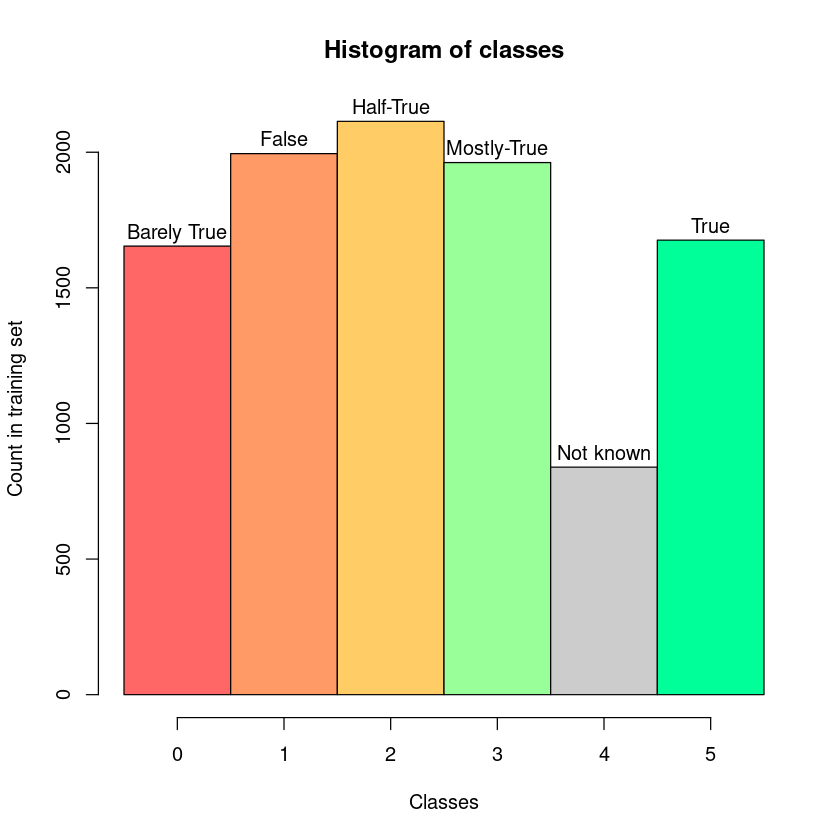

In [14]:
breaks <- seq(from=-0.5, to=5.5, by=1)
labels <- c('Barely True', 'False', 'Half-True', 'Mostly-True', 'Not known', 'True')
colors <- c('#FF6666','#FF9966', '#FFCC66', '#99FF99' , '#CCCCCC','#00FF99')

class<-hist(x = train.df$Labels, 
     breaks = breaks, 
     labels = labels,
     main = 'Histogram of classes',
     xlab = 'Classes',
     ylab = 'Count in training set',
     col = colors
    )

## Defining the prior of each classes

In [15]:
prior.classes<-class$density

## Stop words

In [17]:
as.list(get_stopwords())$word

[1] "i"          "me"         "my"         "myself"     "we"        
  [6] "our"        "ours"       "ourselves"  "you"        "your"      
 [11] "yours"      "yourself"   "yourselves" "he"         "him"       
 [16] "his"        "himself"    "she"        "her"        "hers"      
 [21] "herself"    "it"         "its"        "itself"     "they"      
 [26] "them"       "their"      "theirs"     "themselves" "what"      
 [31] "which"      "who"        "whom"       "this"       "that"      
 [36] "these"      "those"      "am"         "is"         "are"       
 [41] "was"        "were"       "be"         "been"       "being"     
 [46] "have"       "has"        "had"        "having"     "do"        
 [51] "does"       "did"        "doing"      "would"      "should"    
 [56] "could"      "ought"      "i'm"        "you're"     "he's"      
 [61] "she's"      "it's"       "we're"      "they're"    "i've"      
 [66] "you've"     "we've"      "they've"    "i'd"        "you'd"     
 [71] "he'd"       "she'd"      "we'd"       "they'd"     "i'll"      
 [76] "you'll"     "he'll"      "she'll"     "we'll"      "they'll"   
 [81] "isn't"      "aren't"     "wasn't"     "weren't"    "hasn't"    
 [86] "haven't"    "hadn't"     "doesn't"    "don't"      "didn't"    
 [91] "won't"      "wouldn't"   "shan't"     "shouldn't"  "can't"     
 [96] "cannot"     "couldn't"   "mustn't"    "let's"      "that's"    
[101] "who's"      "what's"     "here's"     "there's"    "when's"    
[106] "where's"    "why's"      "how's"      "a"          "an"        
[111] "the"        "and"        "but"        "if"         "or"        
[116] "because"    "as"         "until"      "while"      "of"        
[121] "at"         "by"         "for"        "with"       "about"     
[126] "against"    "between"    "into"       "through"    "during"    
[131] "before"     "after"      "above"      "below"      "to"        
[136] "from"       "up"         "down"       "in"         "out"       
[141] "on"         "off"        "over"       "under"      "again"     
[146] "further"    "then"       "once"       "here"       "there"     
[151] "when"       "where"      "why"        "how"        "all"       
[156] "any"        "both"       "each"       "few"        "more"      
[161] "most"       "other"      "some"       "such"       "no"        
[166] "nor"        "not"        "only"       "own"        "same"      
[171] "so"         "than"       "too"        "very"       "will"

# Cleaning function

In [21]:
cleaning_tokens <- function(token.df){
    word <- ifelse(endsWith(token.df[,1], "s"), substr(token.df[,1], 1, nchar(token.df[,1]) - 1), token.df[,1])
    word <- ifelse(endsWith(word, "'"), substr(word, 1, nchar(word) - 1), word)
    word <- ifelse(str_detect(word, "[0-9]+"), '--number--', word)
#     word %<>% unique
    return(as.data.frame(word))
}

# Vocabulary

In [111]:
tags_numbers <- list(tags = c('Barely True', 'False', 'Half-True', 'Mostly-True', 'Not known', 'True'),
                     numbers = c(0:5))

In [112]:
## Vocabulary before feature selection

In [25]:
myframes <- list()

for (i in 1:length(tags_numbers$tags)) {
    tag <- tags_numbers$tags[i]

    train.df.train %>%
        filter(Labels == tags_numbers$numbers[i]) %>%
        select(Text) %>%
        unnest_tokens(word, Text) %>%
        anti_join(get_stopwords(), by = join_by(word)) %>%
        cleaning_tokens %>%
        arrange(word) %>%
        group_by(word) %>%
        reframe(counts = n()) %>%
        arrange(desc(counts)) %>%
        setNames(c("word", tag)) -> myframes[[i]]
}

In [26]:
counts<-purrr::reduce(myframes, dplyr::full_join, by = 'word')

In [27]:
head(counts)

word,Barely True,False,Half-True,Mostly-True,Not known,True
<chr>,<int>,<int>,<int>,<int>,<int>,<int>
--number--,693,784,1106,1157,259,872
say,361,417,411,334,192,268
state,157,214,224,237,60,228
year,154,170,217,224,45,178
obama,134,164,142,84,105,73
percent,121,129,216,243,34,191


In [28]:
counts %<>% replace(is.na(.),0)

## Feature Selection 

## With frequency mean

In [160]:
counts %>%
    select(-word) %>%
    colSums() -> tot_counts_per_class

In [161]:
counts_prob <- cbind(counts["word"], counts[2:7]/tot_counts_per_class)

In [162]:
counts_prob["mean"] <- rowMeans(counts_prob[2:7])

In [163]:
counts_prob %>%
    arrange(desc(mean)) %>%
    top_frac(1, mean) -> vocabulary.train.features

In [164]:
head(vocabulary.train.features)

,word,Barely True,False,Half-True,Mostly-True,Not known,True,mean
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,--number--,0.045383104,0.043625842,0.072429601,0.064381504,0.016961362,0.04852262,0.048550672
2,say,0.020790141,0.056146493,0.023669661,0.044971052,0.011057360,0.03608456,0.032119877
3,obama,0.018042278,0.009444828,0.019119429,0.004837595,0.014137606,0.00420410,0.011630973
4,state,0.007935305,0.014492754,0.011321708,0.016050386,0.003032600,0.01544088,0.011378938
5,year,0.008569362,0.011132940,0.012075010,0.014669286,0.002504034,0.01165684,0.010101246
6,tax,0.005471090,0.014676181,0.006450127,0.014541538,0.002361207,0.01050222,0.009000394


In [165]:
counts %>%
    right_join(vocabulary.train.features["word"], by = join_by(word)) -> naive.bayes.vocabulary

In [166]:
length(naive.bayes.vocabulary[[1]])

[1] 9075

In [167]:
den <- tot_counts_per_class + length(naive.bayes.vocabulary[[1]])

In [168]:
den

Barely True       False   Half-True Mostly-True   Not known        True 
      24345       26439       28860       27046       16502       23841

In [169]:
likelihood.token <- cbind(naive.bayes.vocabulary["word"], (naive.bayes.vocabulary[2:7] + 1)/den)

## Nayve Bayes

In [170]:
# is.na(log(as.numeric(likelihood.token[likelihood.token['word']=='ciao'][2:6])))

# is.na(likelihood.token[likelihood.token['word']=='ciao'])

In [171]:
msg<-c('obama', 'percent', 'tommasomarco')

In [172]:
bayes.probability <- function(token.list, likelihood.token, prior.classes){
    query_out <- log(as.numeric(prior.classes))
    for (i in 1:length(token.list)) {
        query <- log(as.numeric(likelihood.token[likelihood.token["word"] == token.list[i]][2:7]))
        if (is.na(query[1])) {
        query <- as.numeric(log(1/den))
        }
    #### query is log likelihood for each class
        query_out <- query_out + query
    
    }
    query_out <- exp(query_out)
    query_out <- query_out/sum(query_out)
    return(query_out)
}

In [173]:
naive.bayes(msg, likelihood.token, prior.classes)

[1] 1

In [174]:
tweet_tokenize <- function(msg){
    tib <- data.frame(msg)
    colnames(tib) <- 'tweet'
    tib %>% unnest_tokens(word, tweet) %>%
    anti_join(get_stopwords(), by = join_by(word)) %>%
    cleaning_tokens -> token.list
    return(token.list)    
}

In [175]:
naive.bayes <- function(msg, likelihood.token, prior.classes){
    token.list<-as.vector(tweet_tokenize(msg))
    probability <- bayes.probability(token.list,likelihood.token, prior.classes )
    predicted_class <- which.max(probability)-1
    return(predicted_class)
}

## Test on validation set

In [176]:
naive.bayes('Mister Obama joins nato', likelihood.token, prior.classes)

Warning message in FUN(left, right):
“la lunghezza più lunga dell'oggetto non è un multiplo della lunghezza più corta dell'oggetto”


[1] 1

In [177]:
predicted_classes <- lapply(X=train.df.validation$Text[1:20], FUN=naive.bayes,likelihood.token=likelihood.token,prior.classes=prior.classes)

Warning message in FUN(left, right):
“la lunghezza più lunga dell'oggetto non è un multiplo della lunghezza più corta dell'oggetto”
Warning message in bayes.probability(token.list, likelihood.token, prior.classes):
“NA introdotti per coercizione”
Warning message in FUN(left, right):
“la lunghezza più lunga dell'oggetto non è un multiplo della lunghezza più corta dell'oggetto”
Warning message in FUN(left, right):
“la lunghezza più lunga dell'oggetto non è un multiplo della lunghezza più corta dell'oggetto”
Warning message in FUN(left, right):
“la lunghezza più lunga dell'oggetto non è un multiplo della lunghezza più corta dell'oggetto”
Warning message in FUN(left, right):
“la lunghezza più lunga dell'oggetto non è un multiplo della lunghezza più corta dell'oggetto”
Warning message in bayes.probability(token.list, likelihood.token, prior.classes):
“NA introdotti per coercizione”
Warning message in FUN(left, right):
“la lunghezza più lunga dell'oggetto non è un multiplo della lunghezza pi

In [178]:
tweet_tokenize('Ciao tommaso come va?')

word
<chr>
ciao
tommaso
come
va


In [179]:
sum(predicted_classes==train.df.validation$Labels[1:20])

[1] 3

In [159]:
predicted_classes

[[1]]
[1] 1

[[2]]
[1] 2

[[3]]
[1] 3

[[4]]
[1] 1

[[5]]
[1] 5

[[6]]
[1] 3

[[7]]
[1] 1

[[8]]
[1] 1

[[9]]
[1] 0

[[10]]
[1] 1

[[11]]
[1] 1

[[12]]
[1] 1

[[13]]
[1] 1

[[14]]
[1] 1

[[15]]
[1] 1

[[16]]
[1] 1

[[17]]
[1] 1

[[18]]
[1] 1

[[19]]
[1] 1

[[20]]
[1] 2

In [106]:
train.df.validation$Labels[1:20]

[1] 2 2 1 5 3 1 5 2 5 3 1 1 4 2 3 3 5 0 3 2

In [101]:
train.df.validation

,Labels,Text,Text_Tag
,<int>,<chr>,<chr>
5743,2,"It is projected that 3.07 million people will use the train annually. Keep in mind that Amtraks Acela train in Washington D.C., Boston, Philadelphia, New York and Baltimore only had 3.2 million riders in 2010.","state-budget,stimulus,transportation"
7339,2,On whether to eliminate the state income tax.,"economy,state-budget,taxes"
5518,1,HIV/AIDS among women is skyrocketing in Austin.,"city-budget,city-government,health-care,public-health,women"
10006,5,"Switzerland and the Netherlands . . . cover all their citizens using private insurers, and they do so for much less cost.",health-care
305,3,If you got rid of the income tax today you'd have about as much revenue as we had 10 years ago.,taxes
5388,1,"President Obama's bill won't bring down the costs (of health care) for average Americans -- or really for very few Americans, if any.",health-care
8104,5,Our economy actually shrank during the last three months of 2012.,"economy,jobs"
4516,2,Says Ellen Rosenblum has said over and over again that this is a job where 80 percent of the job is being the governments lawyer.,"candidates-biography,message-machine-2012"
6630,5,"Says Scott Walker wants to make abortion illegal, even in cases of rape, incest or to protect the life of the mother.","abortion,message-machine"


In [55]:
tib <- tibble('Ciao tommaso come va?')
colnames(tib) <- 'tweet'

In [61]:
tib %>% unnest_tokens(word, tweet)

word
<chr>
ciao
tommaso
come
va


## With absolute counts per class
To implement

In [ ]:
# train.df.train %>%
#     filter(Labels == 5) %>%
#     select(Text) %>%
#     unnest_tokens(word, Text) %>%
#     anti_join(get_stopwords(), by = join_by(word)) %>%
#     arrange(word) %>%
#     group_by(word) %>%
#     reframe(counts=n()) %>%
#     arrange(desc(counts)) -> true

## Naive Bayes Classifier

#### Some suggestion to create equivalence classes

In [ ]:
vocabulary.train %>%
    filter(grepl("al", word)) %>%
    head

In [ ]:
vocabulary.train.cleaned %>%
    filter(grepl("\\'s", word))

In [ ]:
train.df %>%
    filter(grepl("06", Text)) %>%
    filter(!grepl("2006", Text))  #%>% summarise(n())

## About the data

# Count how many topics there are

In [ ]:
train.df.train %>%
    select(Text_Tag) %>%
    unnest_tokens(word, Text_Tag, token = stringr::str_split, pattern = ",") %>%
    unique %>%
    arrange(word) -> topics

In [ ]:
train.df.train  %>% filter(Text_Tag=='')

In [ ]:
topics<-as.list(topics)$word

#### Number of unique topics

In [ ]:
length(topics)

#### Most frequent and infrequent topics

In [ ]:
counts<-vector()
for(i in seq_along(topics)){
    counts[i]<- as.numeric(train.df.train %>% filter(grepl(topics[i], Text_Tag)) %>% summarise(n()))
    }

In [ ]:
topics_counts <- data.frame(topics, counts)

In [ ]:
topics_counts %>%
    filter(topics != "") %>%
    arrange(desc(counts)) %>%
    head()

In [ ]:
topics_counts %>%
    arrange(counts) %>%
    head()